In [45]:
PATH = "/home/WUR/katz001/PROJECTS/permit-nsti-gas"

import os
import numpy as np
import json
import pandas as pd
import sys 
import seaborn as sns
import joblib
import pickle
sys.path.append(f"{PATH}/scripts")

import matplotlib.pyplot as plt 

from func_preprocess import pipe_imputation_scaling, pipe_supervisedSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import RocCurveDisplay, roc_curve

sns.set_theme(style="white", font_scale=1.3)



# ROC-AUC curve (pre-surgery)

In [49]:
datasetTimepoint = "PRESURGERY"
target = "Conclusion_micro"

folderFigures = f"{PATH}/figures/{datasetTimepoint}/50_externalValidation"

In [47]:
''' Load Development Data '''
n_iter = 200
resultsPath = f"{PATH}/results/40_internalValidation/{datasetTimepoint}"
with open(f'{resultsPath}/bootstrap_rfc_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary = pickle.load(f)


''' Load Validation Data '''
n_iter = 200
resultsPath = f"{PATH}/results/50_externalValidation/{datasetTimepoint}"
with open(f'{resultsPath}/bootstrap_validation_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_val = pickle.load(f)


''' Load Validation Data '''
n_iter = 1000
resultsPath = f"{PATH}/results/50_externalValidation/{datasetTimepoint}/finetune"
with open(f'{resultsPath}/bootstrap_0.3_n{n_iter}_qc.pickle', 'rb') as f:
    dic_summary_val_finetune = pickle.load(f)   

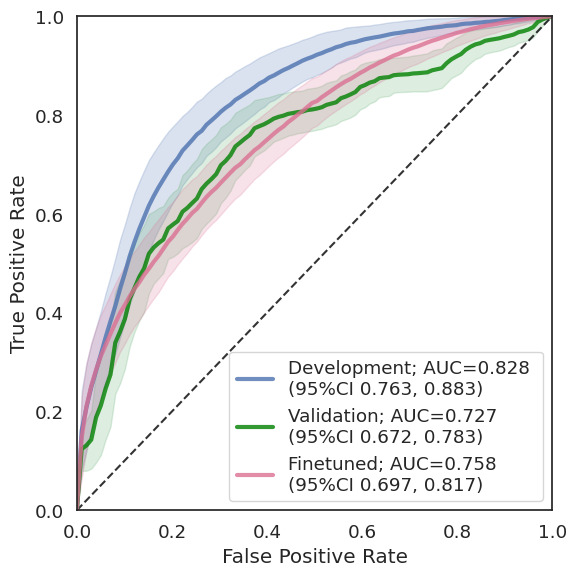

In [50]:
fig, ax = plt.subplots(figsize=(6, 6))
mean_fpr = np.linspace(0, 1, 100)


''' Development '''
tprs = []
fpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=f"Development; AUC=0.828 \n(95%CI 0.763, 0.883)",
    lw=3,
    alpha=0.8,
)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="b",
    alpha=0.2,
    label="",
)    


''' Validation '''
tprs_val = []
fpr = pd.DataFrame.from_dict(dic_summary_val).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_val).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs_val.append(interp_tpr)

mean_tpr = np.mean(tprs_val, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="green",
    label=f"Validation; AUC=0.727 \n(95%CI 0.672, 0.783)",  ## 0.727 (0.672, 0.783)
    #label=f"Validation; \nAUC=0.727 (0.672, 0.783)",  ## 0.727 (0.672, 0.783)
    lw=3,
    alpha=0.8,
)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr - std_tpr_val, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower_val,
    tprs_upper_val,
    color="g",
    alpha=0.2,
    label="",
)    


''' EXTRA - finetune '''

tprs_val = []
fpr = pd.DataFrame.from_dict(dic_summary_val_finetune).T.loc[:,"fpr"]
tpr = pd.DataFrame.from_dict(dic_summary_val_finetune).T.loc[:,"tpr"]
for i in range(fpr.shape[0]):
    interp_tpr = np.interp(mean_fpr, fpr[i], tpr[i])
    interp_tpr[0] = 0.0
    tprs_val.append(interp_tpr)

mean_tpr = np.mean(tprs_val, axis=0)
mean_tpr[-1] = 1.0
ax.plot(
    mean_fpr,
    mean_tpr,
    color="palevioletred",
    #label=f"Finetuned",
    label=f"Finetuned; AUC=0.758 \n(95%CI 0.697, 0.817)",  ## 0.727 (0.672, 0.783)
    lw=3,
    alpha=0.8,
)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr - std_tpr_val, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower_val,
    tprs_upper_val,
    color="palevioletred",
    alpha=0.2,
    label="",
)    





''' General '''
ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle="--", color="black", alpha=.8, zorder=1)

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.legend()
plt.tight_layout()


plt.savefig(f"{folderFigures}/ROC_curves.png", dpi=300)
plt.savefig(f"{folderFigures}/ROC_curves.pdf", dpi=300)

